# 第11章 クラスタ分析 - ラベルなしデータの分析

* https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch11/ch11.ipynb
* よく知られている k-means(k平均法)を使って類似点の中心を見つけ出す
* 階層的クラスタ木をボトムアップ方式で構築する
* 密度に基づくクラスタリングアプローチを使ってオブジェクトの任意の形状を識別する

## 11.1 k-means 法を使った類似度によるオブジェクトのグループ化

* k-means法(k-means algorithm)
* プロトタイプベース(prototype-based)クラスタリング
  * セントロイド(centroid): 特徴量が連続値の場合に、類似する点の「中心」を表す
  * メドイド(medoid): 特徴量がカテゴリ値の場合に、最も「代表的」または最も頻度の高い点を表す
* 階層的(hierarchical)クラスタリング
* 密度(density-based)ベースクラスタリング
* クラスタリングの品質を評価する
  * エルボー法(elbow method)
  * シルエット図(silhouette plot)


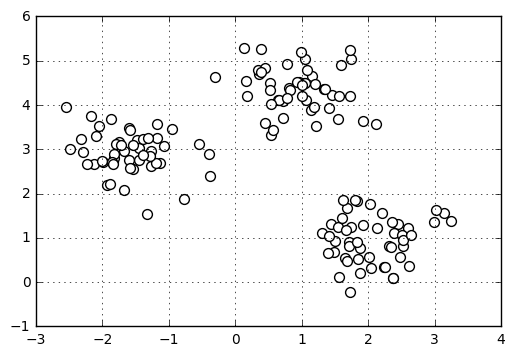

In [2]:
# 単純な2次元のデータセットを生成する
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150,   # サンプル点の総数
                  n_features=2,    # 特徴量の個数
                  centers=3,       # クラスタの個数
                  cluster_std=0.5, # クラスタ内の標準偏差
                  shuffle=True,    # サンプルをシャッフル
                  random_state=0)  # 乱数生成器の状態を指定

import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c='white', marker='o', s=50)
plt.grid()
plt.show()

k-means法の手続き

1. クラスタの中心の初期値として、サンプル点からk個のセントロイドをランダムに選び出す
2. 各サンプルを最も近いセントロイドμ(i)に割り当てる
3. セントロイドに割り当てられたサンプルの中心にセントロイドを移動する
4. サンプル点へのクラスタの割り当てが変化しなくなるか、ユーザー定義の許容値またはイテレーションの最大回数に達するまで、ステップ2〜3を繰り返す

In [3]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,   # クラスタの個数
            init='random',  # セントロイドの初期値をランダムに選択
            n_init=10,      # 異なるセントロイドの初期値を用いた実行回数
            max_iter=300,   # 最大イテレーション回数
            tol=1e-04,      # 収束と判定するための相対的な許容誤差
            random_state=0) # セントロイドの初期化に用いる乱数生成器の状態
y_km = km.fit_predict(X)    # クラスタの中心の計算と各サンプルのインデックスの予測

### 11.1.1 k-means++ 法

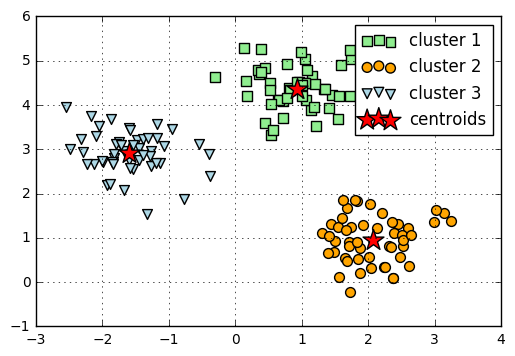

In [4]:
plt.scatter(X[y_km == 0, 0],   # グラフのxの値
            X[y_km == 0, 1],   # グラフのyの値
            s=50,              # プロットのサイズ
            c='lightgreen',    # プロットの色
            marker='s',        # マーカーの形
            label='cluster 1') # ラベル名
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50,
            c='lightblue',
            marker='v',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250,
            marker='*',
            c='red',
            label='centroids')
plt.legend()
plt.grid()
plt.show()

### 11.1.2 ハードクラスタリングとソフトクラスタリング
